In [1]:
from google.colab import drive
drive.mount('/content/drive') # remove the cell if colab is not used

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
base_path = Path('/content/drive/MyDrive/zadanie1/data') # Pass path to data folder here, e.g. Path('/content/drive/MyDrive/data') if using Google Drive

I have decided to remove:
- ['Pclass', 'Ticket', 'Fare', 'Cabin'], as they don't bring much to the statistics
- ['SibSp', 'Parch'] which I will collect together to one column 'Family'
- ['Name'], as now it is of no value for the statistics.

I left out:
- ['Survived', 'Sex', 'Age'], as they seem to be most important
- ['Embarked'] because it may be useful to know where the passengers were possibly from

In [5]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')
needed_columns = ['Survived', 'Sex', 'Age', 'Embarked']

categorical_columns = ['Sex', 'Embarked']

# map Survived to boolean
titanic_df['Survived'] = titanic_df.Survived.map({
    0: False, 1: True
})

titanic_df['Survived'] = titanic_df['Survived'].astype('bool')

# assign dtypes
titanic_df[categorical_columns] = titanic_df[categorical_columns].astype('category')

titanic_df[needed_columns]

,Survived,Sex,Age,Embarked
PassengerId,,,,
1,False,male,22.0,S
2,True,female,38.0,C
3,True,female,26.0,S
4,True,female,35.0,S
5,False,male,35.0,S
...,...,...,...,...
887,False,male,27.0,S
888,True,female,19.0,S
889,False,female,NaN,S


I am skipping the columns I found unuseful in this particular case.

In [6]:
# Adding column Family (if the passenger had family onboard)

family = (titanic_df['SibSp'] != 0) | (titanic_df['Parch'] != 0)

titanic_df['Family'] = family
needed_columns.append('Family')

# Adding column Underage (if the passenger's age < 18)

underage = (titanic_df['Age'] < 18)

titanic_df['Underage'] = underage
needed_columns.append('Underage')

titanic_df[needed_columns]

,Survived,Sex,Age,Embarked,Family,Underage
PassengerId,,,,,,
1,False,male,22.0,S,True,False
2,True,female,38.0,C,True,False
3,True,female,26.0,S,False,False
4,True,female,35.0,S,True,False
5,False,male,35.0,S,False,False
...,...,...,...,...,...,...
887,False,male,27.0,S,False,False
888,True,female,19.0,S,False,False
889,False,female,NaN,S,True,False


From now on we won't use other columns, so we are removing them from our calculations.

In [7]:
to_remove = ['Pclass', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Name']
titanic_df = titanic_df.drop(to_remove, axis=1)

titanic_df

,Survived,Sex,Age,Embarked,Family,Underage
PassengerId,,,,,,
1,False,male,22.0,S,True,False
2,True,female,38.0,C,True,False
3,True,female,26.0,S,False,False
4,True,female,35.0,S,True,False
5,False,male,35.0,S,False,False
...,...,...,...,...,...,...
887,False,male,27.0,S,False,False
888,True,female,19.0,S,False,False
889,False,female,NaN,S,True,False


In [8]:
titanic_df.dtypes

,0
Survived,bool
Sex,category
Age,float64
Embarked,category
Family,bool
Underage,bool


In [9]:
def get_percentage_missing(df, axis):
  missing_rows = df.isna().sum(axis=axis)
  missing_rows_perc = np.round(missing_rows / df.shape[axis] * 100, 2)
  return missing_rows_perc[missing_rows_perc > 0]

get_percentage_missing(titanic_df, axis=0)

,0
Age,19.87
Embarked,0.22


In [10]:
missing_rows = get_percentage_missing(titanic_df, axis=1)

missing_all_values = missing_rows[missing_rows==100].index

titanic_df.loc[missing_all_values]

,Survived,Sex,Age,Embarked,Family,Underage
PassengerId,,,,,,


No empty rows.

A little percentage of Embarked is missing, it may be assigned a new category, e.g. U for "Unknown".

About 20% of Age is missing, so we have to do something about it. We'll try assigning the median.

In [11]:
if 'U' not in titanic_df['Embarked'].cat.categories:
  titanic_df['Embarked'] = titanic_df['Embarked'].cat.add_categories('U')
titanic_df['Embarked'].fillna('U', inplace=True)

get_percentage_missing(titanic_df, axis=0)

/tmp/ipython-input-4038159145.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df['Embarked'].fillna('U', inplace=True)


,0
Age,19.87


In [12]:
# We will be using the median from proper Sex value

titanic_df['Age'] = titanic_df.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.median()))

get_percentage_missing(titanic_df, axis=0)

/tmp/ipython-input-1281686862.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic_df['Age'] = titanic_df.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.median()))


,0


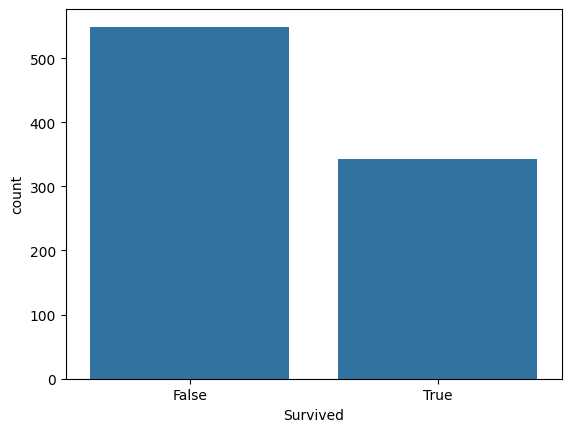

In [13]:
# plot values in Survived

sns.countplot(data=titanic_df, x='Survived')

plt.show()

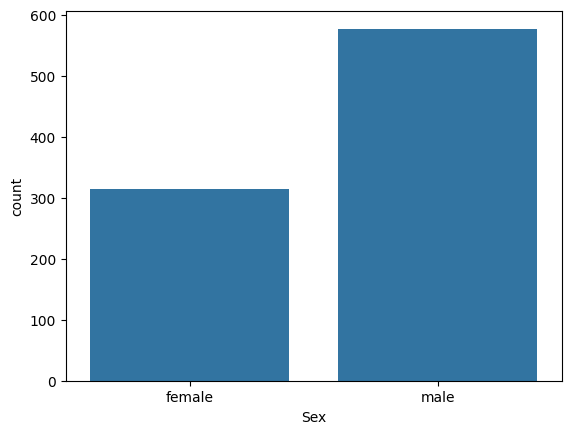

In [14]:
# plot values in Sex (no outliers)

sns.countplot(data=titanic_df, x='Sex')

plt.show()

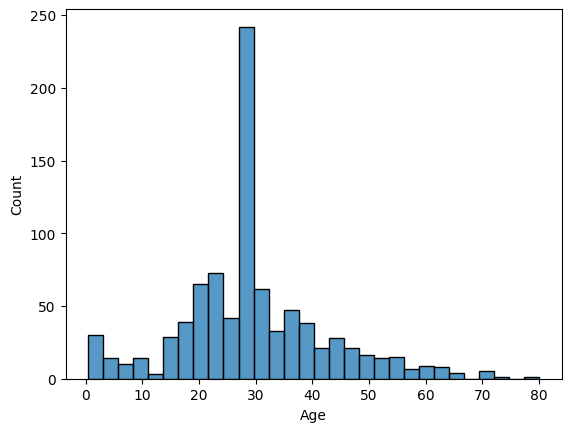

In [15]:
# plot values in Age

sns.histplot(data=titanic_df, x='Age')

plt.show()

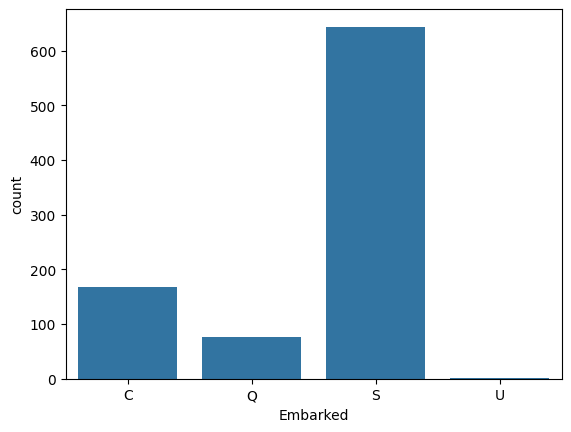

In [16]:
# plot values in Embarked (no outliers)

sns.countplot(data=titanic_df, x='Embarked')

plt.show()

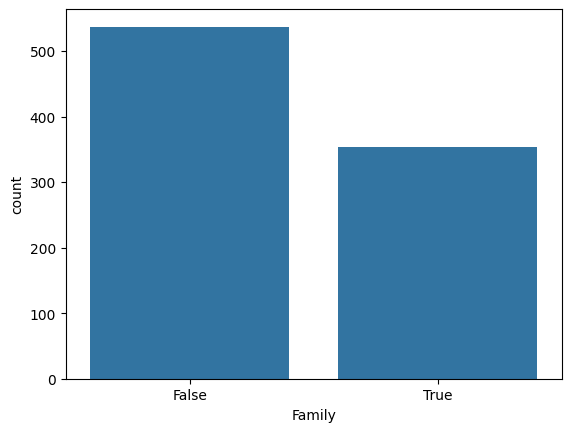

In [17]:
# plot values in Family

sns.countplot(data=titanic_df, x='Family')

plt.show()

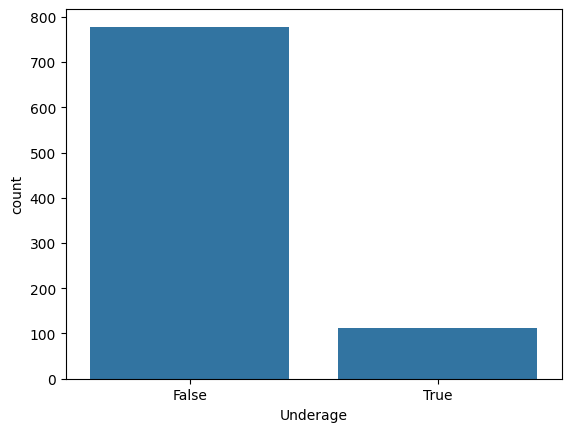

In [18]:
# plot values in Underage

sns.countplot(data=titanic_df, x='Underage')

plt.show()

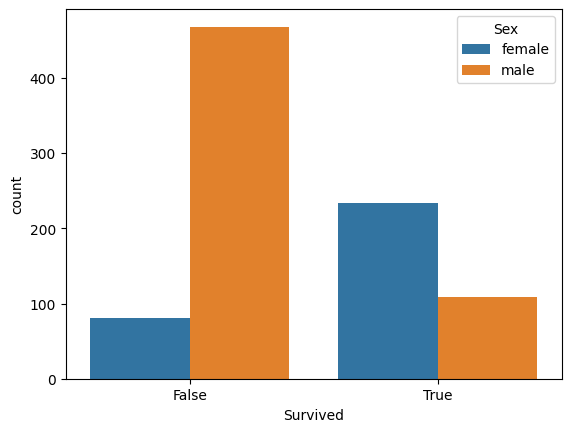

In [19]:
# plot values in Survived by Sex

sns.countplot(data=titanic_df, x='Survived', hue='Sex')

plt.show()

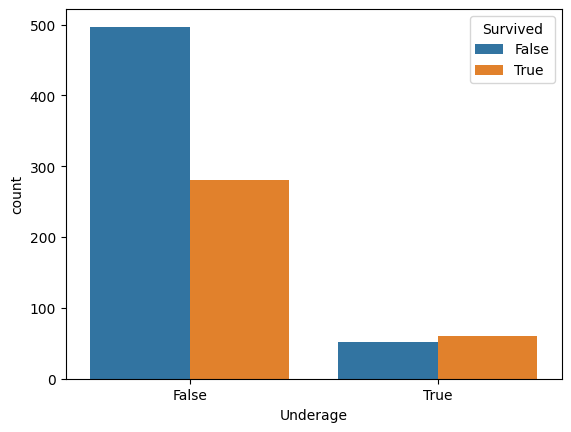

In [ ]:
# plot values in Survived by Underage

sns.countplot(data=titanic_df, x='Underage', hue='Survived')

plt.show()

In [ ]:
n = titanic_df.shape[0]

n # Was 891 on start

891

In [20]:
# Final data

titanic_df

,Survived,Sex,Age,Embarked,Family,Underage
PassengerId,,,,,,
1,False,male,22.0,S,True,False
2,True,female,38.0,C,True,False
3,True,female,26.0,S,False,False
4,True,female,35.0,S,True,False
5,False,male,35.0,S,False,False
...,...,...,...,...,...,...
887,False,male,27.0,S,False,False
888,True,female,19.0,S,False,False
889,False,female,27.0,S,True,False
